# Notebook 4: Assessment and Evaluation
## Introduction
# Loads models/data from Notebook 3, evaluates on test set with MAE/RMSE/AQI metrics, XAI via SHAP.
# Justification: MAE/RMSE for regression accuracy; weighted F1 for imbalanced AQI classes. SHAP for interpretability in sustainability apps.


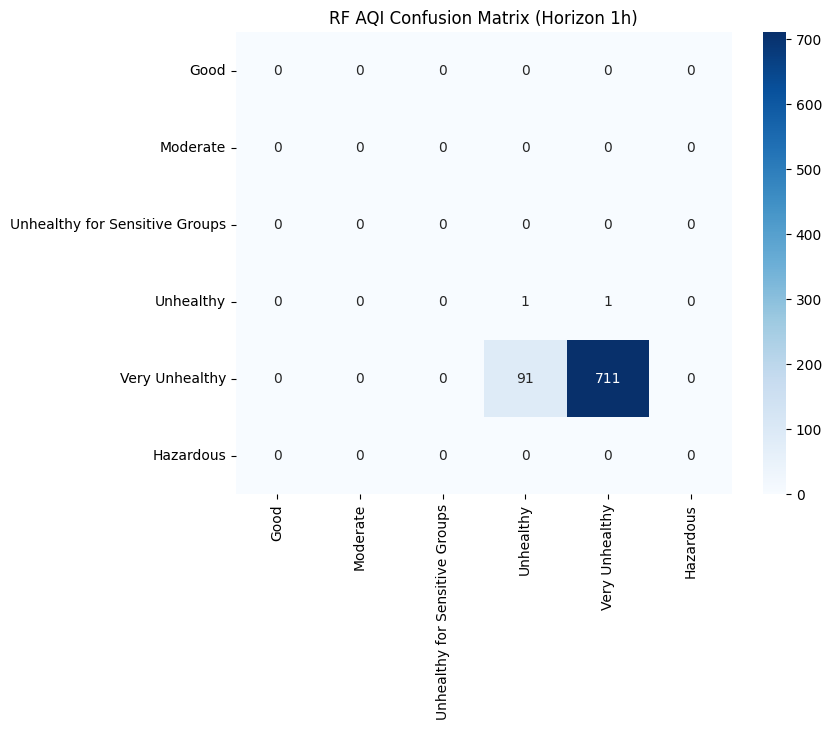

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


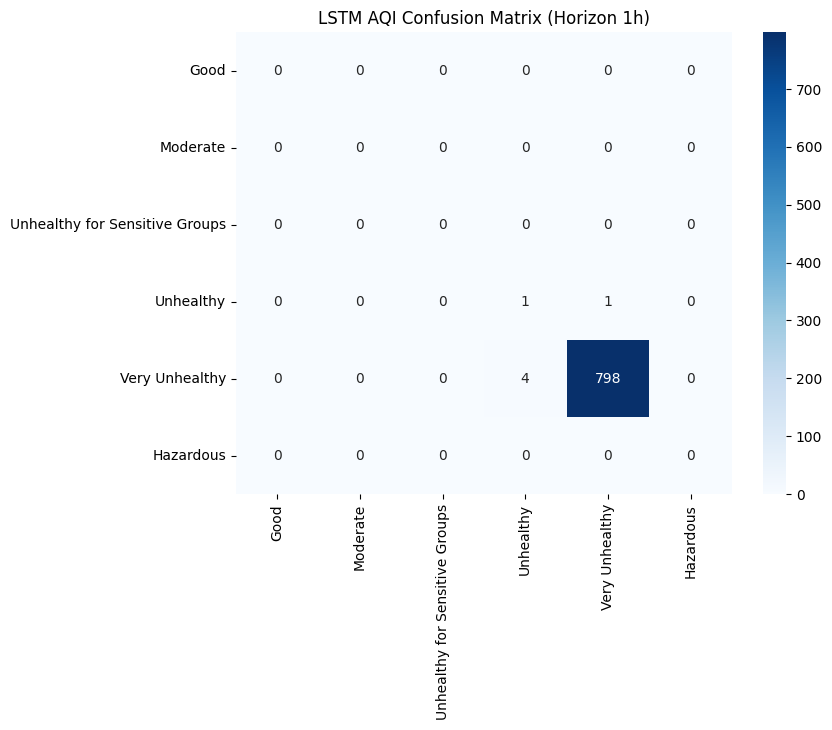

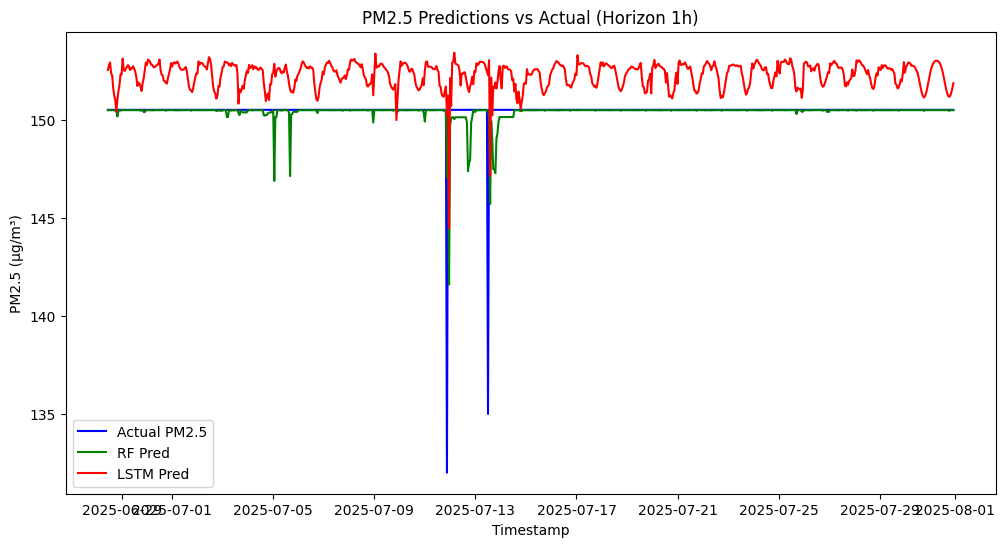

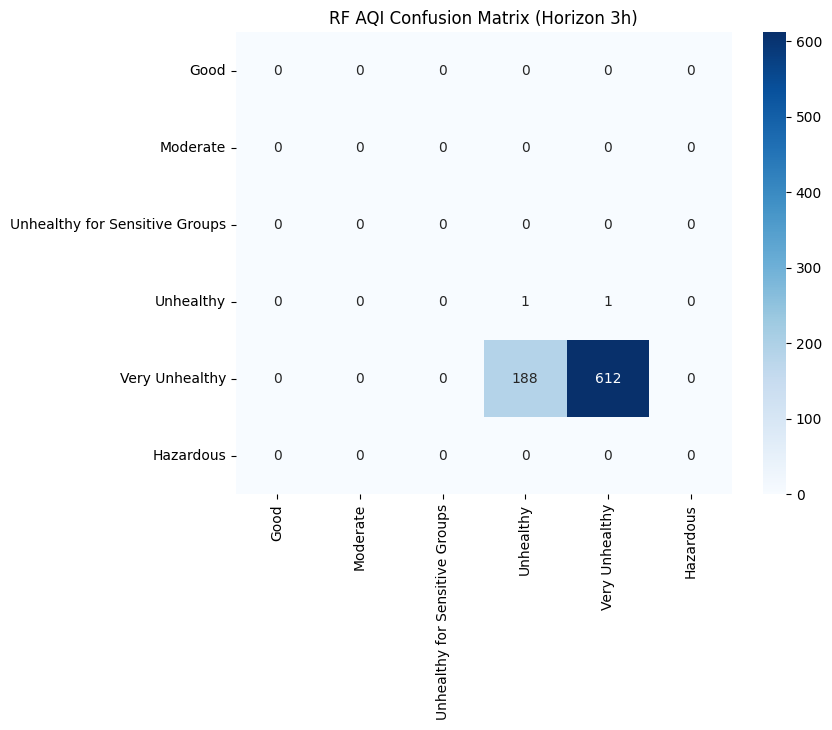

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


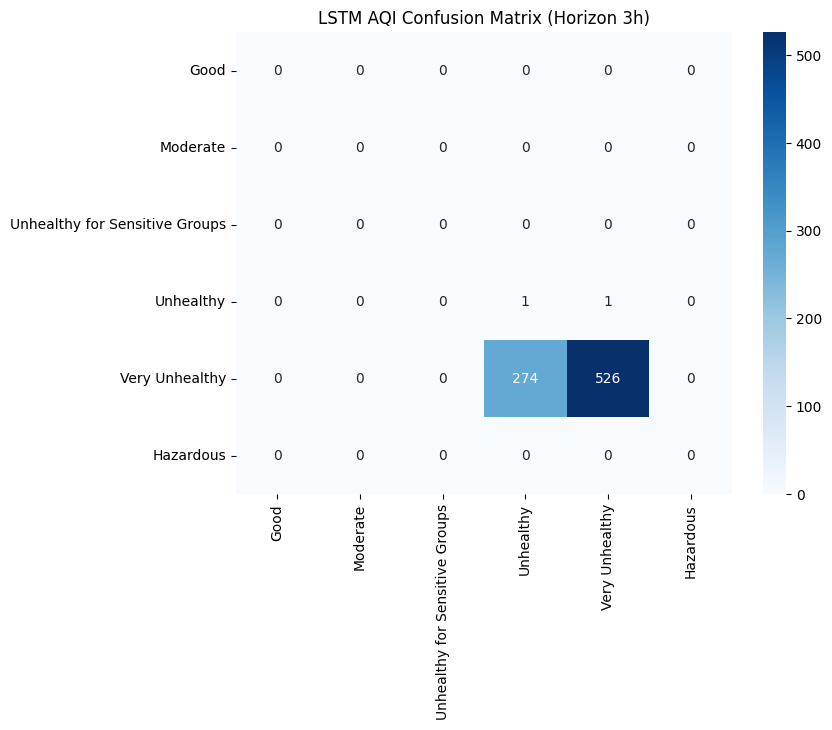

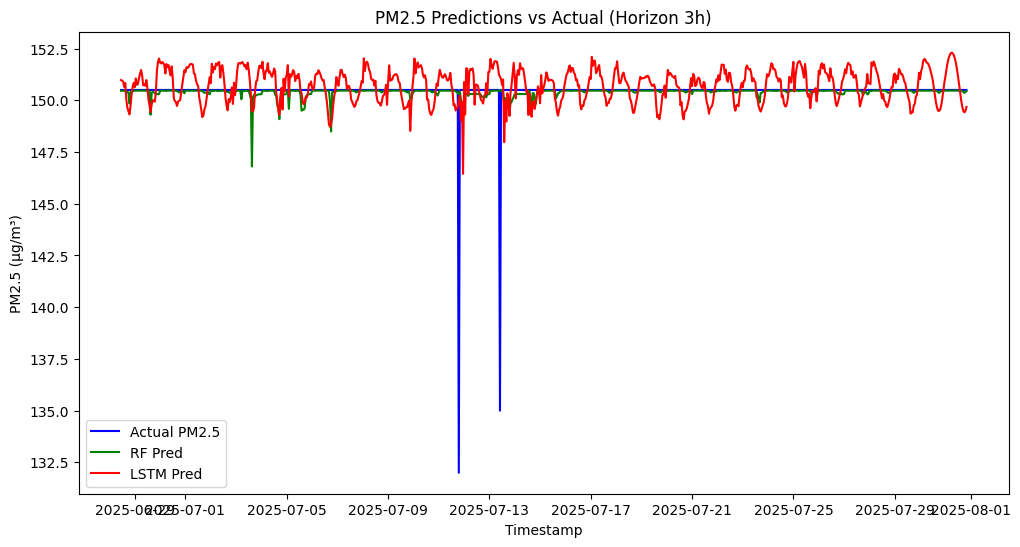

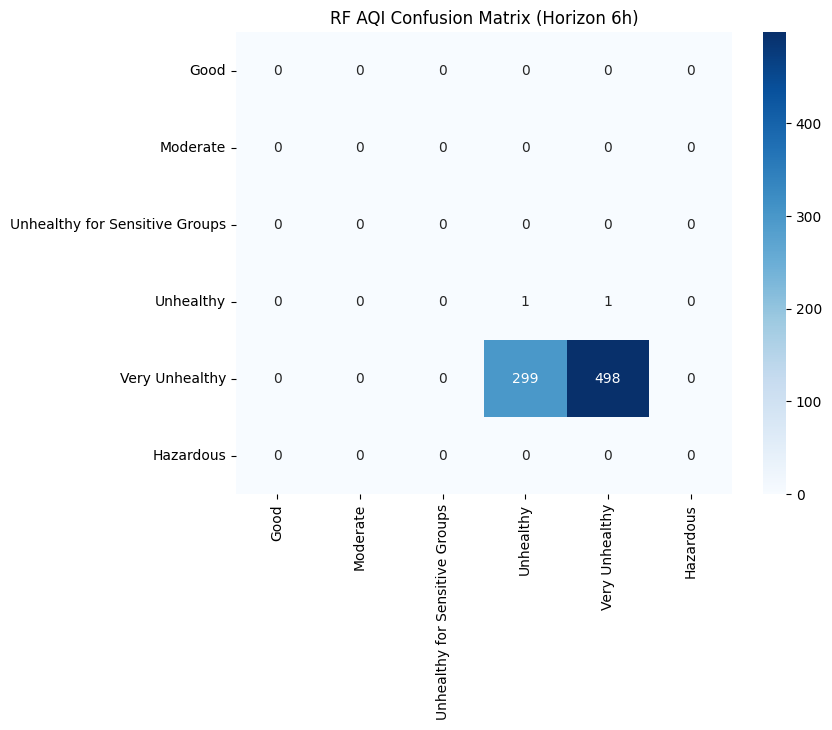

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


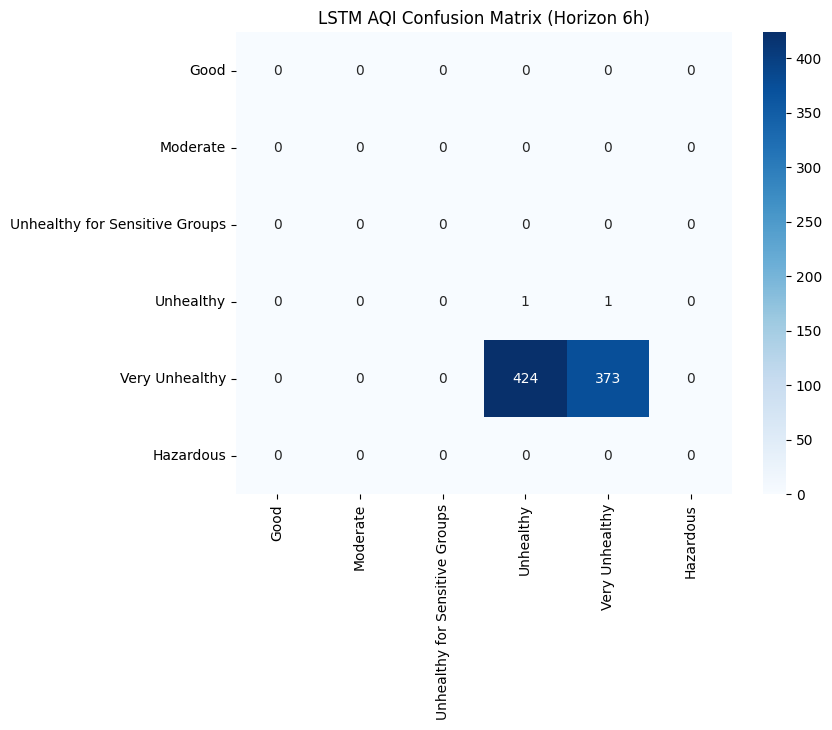

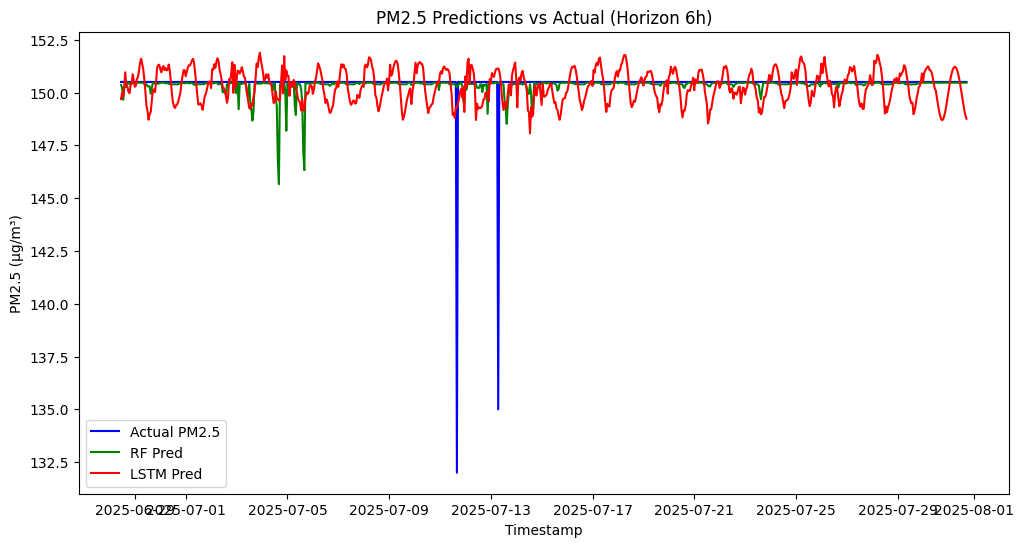

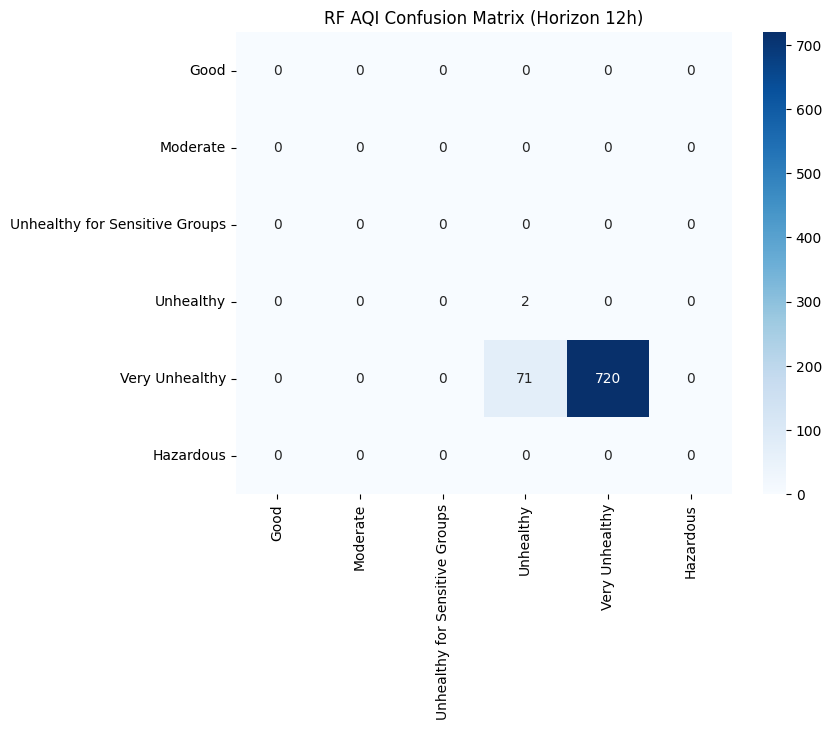

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


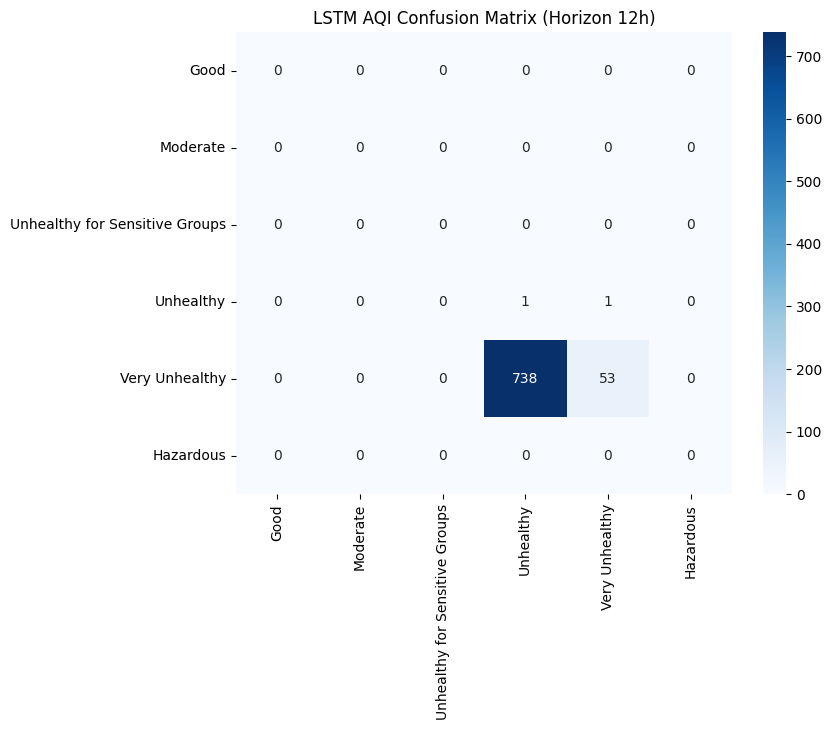

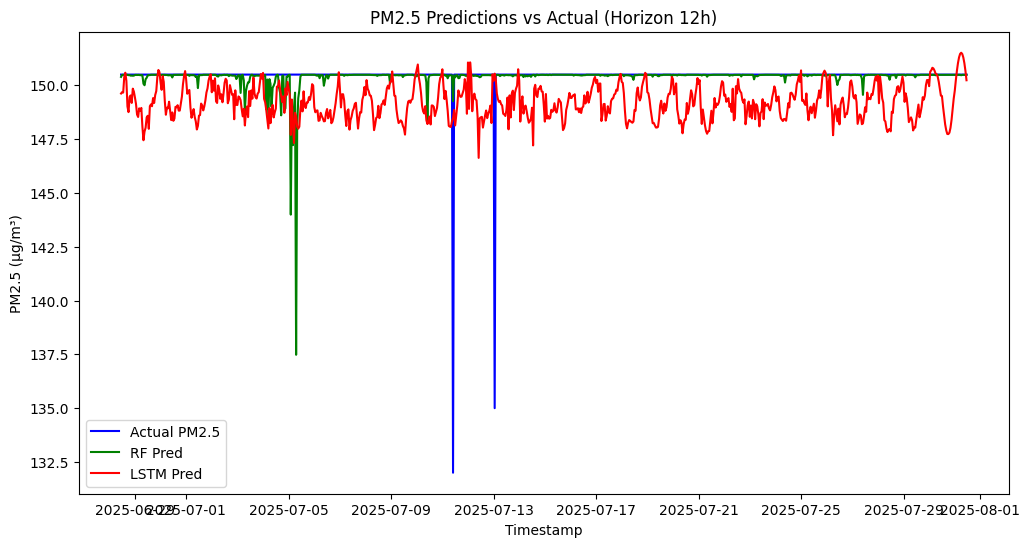

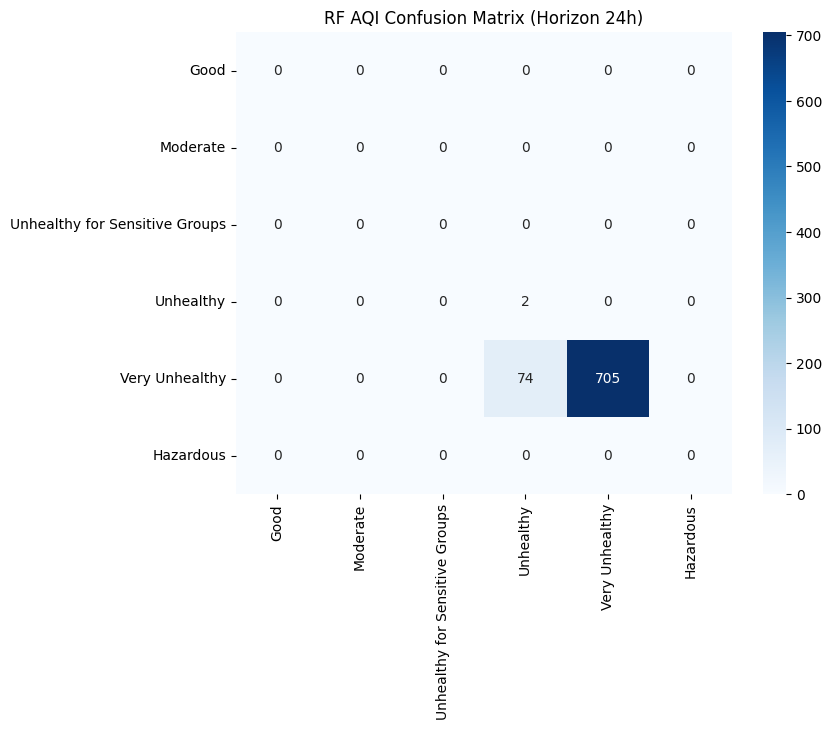

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


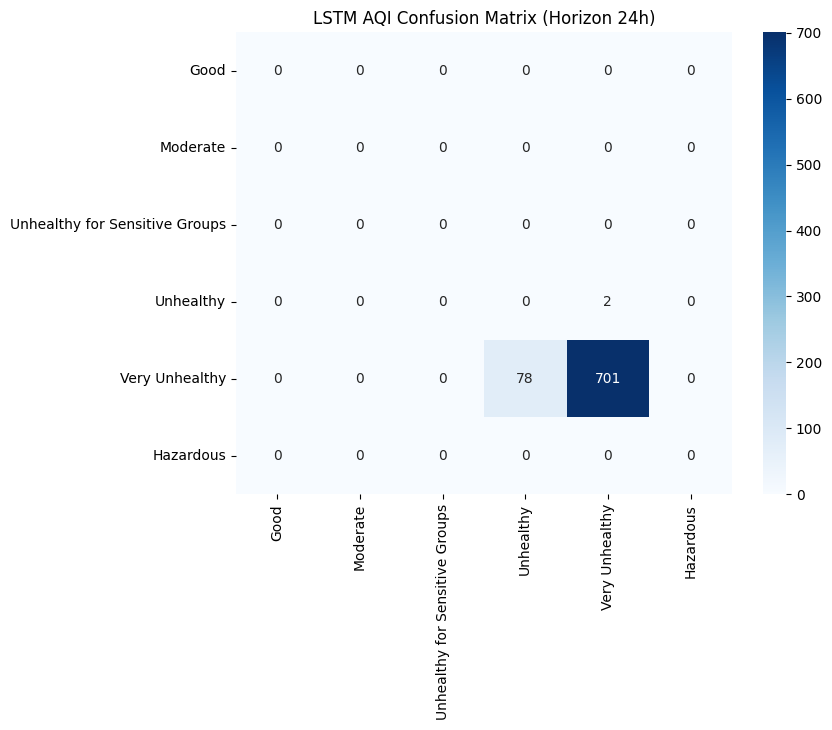

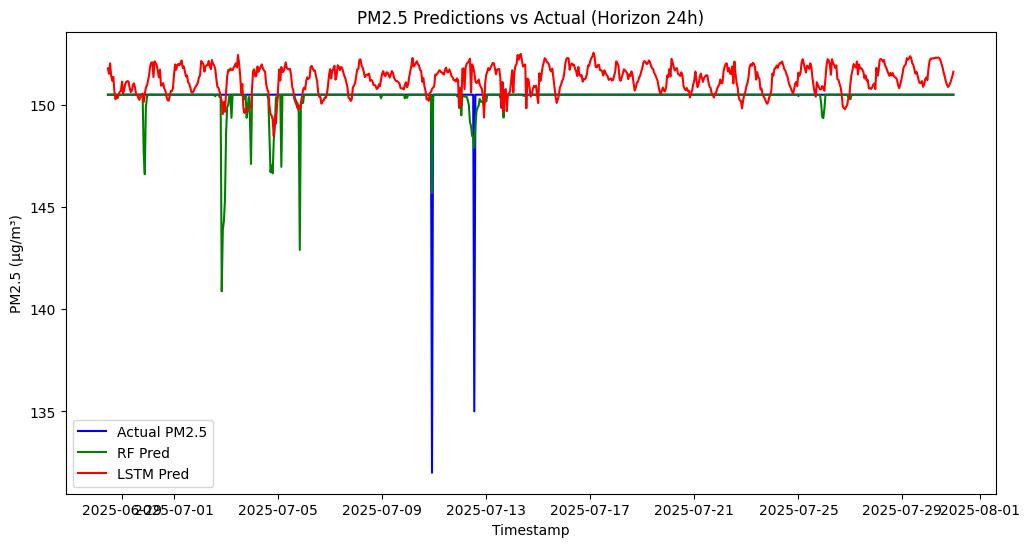

   Horizon Model       MAE      RMSE  AQI Accuracy    AQI F1
0        1    RF  0.140090  0.908283      0.885572  0.936950
1        1  LSTM  1.862474  2.105442      0.993781  0.995108
2        3    RF  0.147128  0.878235      0.764339  0.864108
3        3  LSTM  0.730691  1.172314      0.657107  0.790807
4        6    RF  0.183354  0.927136      0.624531  0.766611
5        6  LSTM  0.671811  1.129300      0.468085  0.635479
6       12    RF  0.138815  1.003716      0.910467  0.950742
7       12  LSTM  1.357209  1.696821      0.068096  0.125134
8       24    RF  0.162188  0.977383      0.905250  0.947833
9       24  LSTM  0.934177  1.360047      0.897567  0.943596


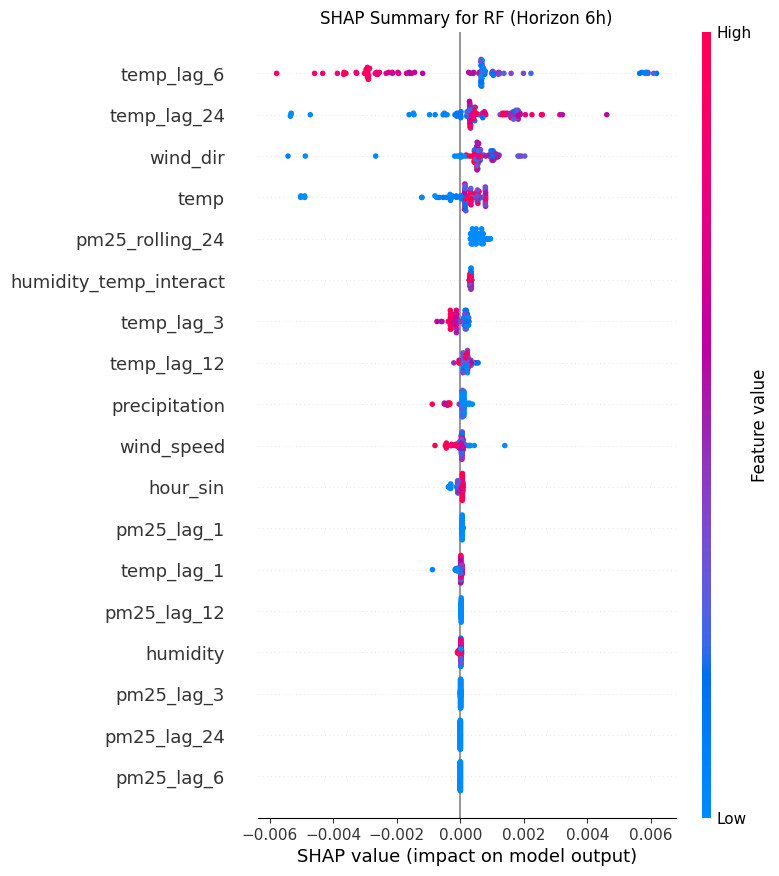

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
3238/3238 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
3238/3238 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
3238/3238 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3238/3238 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
3238/3238 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3238/3238 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
3238/3238 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3238/3238 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
3238/3238 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3238/3238 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3238/3238 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3238/3238 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

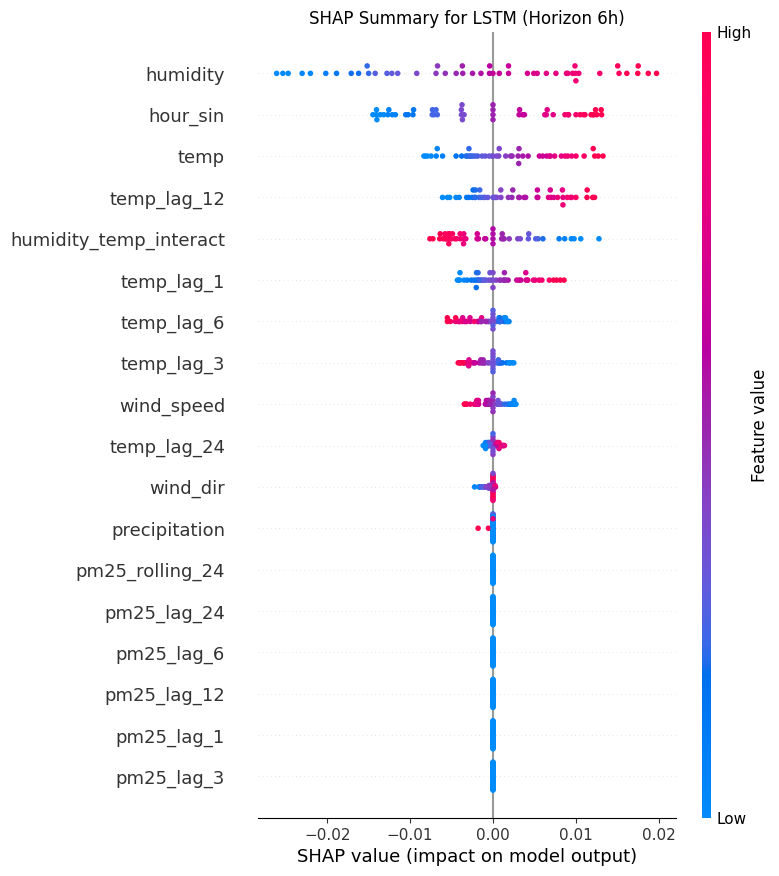

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
import joblib
from tensorflow.keras.models import load_model
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Load featured data (from Notebook 3)
df = pd.read_csv('/content/drive/MyDrive/sus-lsa/featured_data.csv', index_col=0, parse_dates=True)
train_size = int(len(df) * 0.8)
test_df = df.iloc[train_size:]
features = [col for col in df.columns if col not in ['pm25_value', 'target']]
X_test = test_df[features]

# Full AQI calculation for PM2.5 (US EPA breakpoints; Justification: Standard for classification, enables sustainability alerts)
def calculate_pm25_aqi(pm25):
    if pm25 <= 12.0:
        return 50 * pm25 / 12.0
    elif pm25 <= 35.4:
        return 50 + (50 * (pm25 - 12.0) / (35.4 - 12.0))
    elif pm25 <= 55.4:
        return 100 + (50 * (pm25 - 35.4) / (55.4 - 35.4))
    elif pm25 <= 150.4:
        return 150 + (50 * (pm25 - 55.4) / (150.4 - 55.4))
    elif pm25 <= 250.4:
        return 200 + (100 * (pm25 - 150.4) / (250.4 - 150.4))
    elif pm25 <= 350.4:
        return 300 + (100 * (pm25 - 250.4) / (350.4 - 250.4))
    elif pm25 <= 500.4:
        return 400 + (100 * (pm25 - 350.4) / (500.4 - 350.4))
    else:
        return 500  # Cap at 500 for beyond scale to avoid division by zero

def get_aqi_category(aqi):
    if aqi <= 50: return 'Good'
    elif aqi <= 100: return 'Moderate'
    elif aqi <= 150: return 'Unhealthy for Sensitive Groups'
    elif aqi <= 200: return 'Unhealthy'
    elif aqi <= 300: return 'Very Unhealthy'
    else: return 'Hazardous'

results = []
horizons = [1, 3, 6, 12, 24]
aqi_categories_list = ['Good', 'Moderate', 'Unhealthy for Sensitive Groups', 'Unhealthy', 'Very Unhealthy', 'Hazardous']
for h in horizons:
    # Load scaler_y for this horizon
    scaler_y = joblib.load(f'/content/drive/MyDrive/sus-lsa/scaler_y_h{h}.pkl')

    # Adjust test set for horizon (drop last h rows for y_test alignment)
    test_df_h = test_df.iloc[:-h] if h > 0 else test_df
    X_test_h = test_df_h[features]
    y_test_h = test_df['pm25_value'].shift(-h).dropna()[:len(X_test_h)]  # Unscaled actual

    # RF Evaluation
    rf = joblib.load(f'/content/drive/MyDrive/sus-lsa/rf_model_h{h}.pkl')
    rf_pred_scaled = rf.predict(X_test_h)
    rf_pred = scaler_y.inverse_transform(rf_pred_scaled.reshape(-1, 1)).flatten()  # Inverse to original
    mae_rf = mean_absolute_error(y_test_h, rf_pred)
    rmse_rf = np.sqrt(mean_squared_error(y_test_h, rf_pred))
    y_pred_rf_series = pd.Series(rf_pred, index=y_test_h.index)
    y_test_aqi_values = pd.Series(y_test_h).apply(calculate_pm25_aqi).dropna()
    y_test_aqi_cats = y_test_aqi_values.apply(get_aqi_category)
    y_pred_rf_aqi_values = y_pred_rf_series.apply(calculate_pm25_aqi).dropna()
    y_pred_rf_aqi_cats = y_pred_rf_aqi_values.apply(get_aqi_category)
    common_idx_rf = y_test_aqi_cats.index.intersection(y_pred_rf_aqi_cats.index)
    if not common_idx_rf.empty:
        report_rf = classification_report(y_test_aqi_cats.loc[common_idx_rf], y_pred_rf_aqi_cats.loc[common_idx_rf], labels=aqi_categories_list, zero_division=0, output_dict=True)
        aqi_acc_rf = report_rf['accuracy']
        aqi_f1_rf = report_rf['weighted avg']['f1-score']
        cm_rf = confusion_matrix(y_test_aqi_cats.loc[common_idx_rf], y_pred_rf_aqi_cats.loc[common_idx_rf], labels=aqi_categories_list)
        plt.figure(figsize=(8,6))
        sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=aqi_categories_list, yticklabels=aqi_categories_list)
        plt.title(f'RF AQI Confusion Matrix (Horizon {h}h)')
        plt.savefig(f'/content/drive/MyDrive/sus-lsa/rf_cm_h{h}.png')
        plt.show()
    else:
        aqi_acc_rf, aqi_f1_rf = np.nan, np.nan
    results.append({'Horizon': h, 'Model': 'RF', 'MAE': mae_rf, 'RMSE': rmse_rf, 'AQI Accuracy': aqi_acc_rf, 'AQI F1': aqi_f1_rf})

    # LSTM Evaluation
    lstm = load_model(f'/content/drive/MyDrive/sus-lsa/lstm_model_h{h}.h5', custom_objects={'mse': tf.keras.losses.MeanSquaredError()})
    X_test_lstm = np.reshape(X_test_h.values, (X_test_h.shape[0], 1, X_test_h.shape[1]))
    lstm_pred_scaled = lstm.predict(X_test_lstm)
    lstm_pred = scaler_y.inverse_transform(lstm_pred_scaled).flatten()  # Inverse to original
    mae_lstm = mean_absolute_error(y_test_h, lstm_pred)
    rmse_lstm = np.sqrt(mean_squared_error(y_test_h, lstm_pred))
    y_pred_lstm_series = pd.Series(lstm_pred, index=y_test_h.index)
    y_pred_lstm_aqi_values = y_pred_lstm_series.apply(calculate_pm25_aqi).dropna()
    y_pred_lstm_aqi_cats = y_pred_lstm_aqi_values.apply(get_aqi_category)
    common_idx_lstm = y_test_aqi_cats.index.intersection(y_pred_lstm_aqi_cats.index)
    if not common_idx_lstm.empty:
        report_lstm = classification_report(y_test_aqi_cats.loc[common_idx_lstm], y_pred_lstm_aqi_cats.loc[common_idx_lstm], labels=aqi_categories_list, zero_division=0, output_dict=True)
        aqi_acc_lstm = report_lstm['accuracy']
        aqi_f1_lstm = report_lstm['weighted avg']['f1-score']
        cm_lstm = confusion_matrix(y_test_aqi_cats.loc[common_idx_lstm], y_pred_lstm_aqi_cats.loc[common_idx_lstm], labels=aqi_categories_list)
        plt.figure(figsize=(8,6))
        sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=aqi_categories_list, yticklabels=aqi_categories_list)
        plt.title(f'LSTM AQI Confusion Matrix (Horizon {h}h)')
        plt.savefig(f'/content/drive/MyDrive/sus-lsa/lstm_cm_h{h}.png')
        plt.show()
    else:
        aqi_acc_lstm, aqi_f1_lstm = np.nan, np.nan
    results.append({'Horizon': h, 'Model': 'LSTM', 'MAE': mae_lstm, 'RMSE': rmse_lstm, 'AQI Accuracy': aqi_acc_lstm, 'AQI F1': aqi_f1_lstm})

    # Plot Predictions vs Actual (for visualization in report)
    plt.figure(figsize=(12,6))
    plt.plot(y_test_h.index, y_test_h, label='Actual PM2.5', color='blue')
    plt.plot(y_test_h.index, rf_pred, label='RF Pred', color='green')
    plt.plot(y_test_h.index, lstm_pred, label='LSTM Pred', color='red')
    plt.title(f'PM2.5 Predictions vs Actual (Horizon {h}h)')
    plt.xlabel('Timestamp')
    plt.ylabel('PM2.5 (µg/m³)')
    plt.legend()
    plt.savefig(f'/content/drive/MyDrive/sus-lsa/preds_h{h}.png')
    plt.show()  # Justification: Visual error analysis; highlights model strengths (e.g., LSTM on trends).

# Save and print results
results_df = pd.DataFrame(results)
results_df.to_csv('/content/drive/MyDrive/sus-lsa/evaluation_results.csv', index=False)
print(results_df)

# XAI: SHAP for RF and LSTM (example for h=6; Justification: TreeExplainer for RF, Kernel for LSTM – reveals key drivers like wind for pollution dispersion)
h_explain = 6
rf = joblib.load(f'/content/drive/MyDrive/sus-lsa/rf_model_h{h_explain}.pkl')
explainer_rf = shap.TreeExplainer(rf)
shap_values_rf = explainer_rf.shap_values(X_test.iloc[:100])  # Sample for speed
shap.summary_plot(shap_values_rf, X_test.iloc[:100], show=False)
plt.title('SHAP Summary for RF (Horizon 6h)')
plt.savefig('/content/drive/MyDrive/sus-lsa/shap_rf_h6.png')
plt.show()

# SHAP for LSTM (KernelExplainer; slower, sample small)
lstm = load_model(f'/content/drive/MyDrive/sus-lsa/lstm_model_h{h_explain}.h5', custom_objects={'mse': tf.keras.losses.MeanSquaredError()})
def lstm_predict(data):
    return lstm.predict(np.reshape(data, (data.shape[0], 1, data.shape[1]))).flatten()
explainer_lstm = shap.KernelExplainer(lstm_predict, X_test.iloc[:50])
shap_values_lstm = explainer_lstm.shap_values(X_test.iloc[50:100])
shap.summary_plot(shap_values_lstm, X_test.iloc[50:100], show=False)
plt.title('SHAP Summary for LSTM (Horizon 6h)')
plt.savefig('/content/drive/MyDrive/sus-lsa/shap_lstm_h6.png')
plt.show()